**Lab 6 – Explainable AI**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math608/blob/master/static_files/presentations/06_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math608/blob/master/static_files/presentations/06_XAI.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# 🛠️ Setup

In [1]:
# @title Install packages
!pip install imodels -qq
!pip install interpret -qq
!pip install dtreeviz -qq
!pip install lime -qq
!pip install shap -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.0/243.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 43.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 15.9 MB/s eta 0:00:00
   ━━━━

In [1]:
# @title Import packages
# Scientific computing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline

# Preprocessing and datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_iris
from sklearn.datasets import fetch_openml

# Modeling
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, accuracy_score
import tensorflow as tf

# Interpretable Models
from imodels import RuleFitRegressor
from imodels import OneRClassifier, GreedyRuleListClassifier, FIGSClassifier, HSTreeClassifierCV
from imodels.discretization import ExtraBasicDiscretizer
from imodels.tree.viz_utils import extract_sklearn_tree_from_figs
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from interpret.perf import RegressionPerf
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
#set_visualize_provider(InlineProvider())

# Model-Agnostic Methods
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

# Local methods
import lime
import lime.lime_tabular
from lime import lime_image
import warnings
# Suppress all DeprecationWarnings from the shap library
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    module=r".*shap.*",
)
warnings.filterwarnings("ignore", message="Argument show_error is set to true, but there are no bounds in the data.")
warnings.filterwarnings("ignore", message="The append_trace method is deprecated and will be removed in a future version.")

# Suppress the specific DeprecationWarning from ipykernel.ipkernel
warnings.filterwarnings(
    "ignore",
    message="`should_run_async` will not call `transform_cell` automatically in the future",
    category=DeprecationWarning,
    module=r".*ipykernel\.ipkernel.*",
)

import shap  # package used to calculate Shap values

# Helper functions
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from scipy.io.arff import loadarff
import graphviz
import dtreeviz

import logging

logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL) # For dtreeviz

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

np.random.seed(13)

def get_ames_data():
    try:
        housing = fetch_openml(name="house_prices", as_frame=True, parser='auto')
    except:
        housing = fetch_openml(name="house_prices", as_frame=True)

    housing_target = housing['target'].values
    housing_data_numeric = housing['data'].select_dtypes('number').drop(columns=['Id']).dropna(axis=1)
    feature_names = housing_data_numeric.columns.values
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        housing_data_numeric.values, housing_target, test_size=0.75)
    return X_train_reg.copy(), X_test_reg.copy(), y_train_reg.copy(), y_test_reg.copy(), feature_names

def get_diabetes_data():
    '''load (classification) data on diabetes
    '''
    data = loadarff("diabetes.arff")
    data_np = np.array(list(map(lambda x: np.array(list(x)), data[0])))
    X = data_np[:, :-1].astype('float32')
    y_text = data_np[:, -1].astype('str')
    y = (y_text == 'tested_positive').astype(int)  # labels 0-1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75)  # split
    feature_names = ["#Pregnant", "Glucose concentration test", "Blood pressure(mmHg)",
                     "Triceps skin fold thickness(mm)",
                     "2-Hour serum insulin (mu U/ml)", "Body mass index", "Diabetes pedigree function", "Age (years)"]
    return X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy(), feature_names

def viz_classification_preds(probs, y_test):
    '''look at prediction breakdown
    '''
    plt.subplot(121)
    plt.hist(probs[:, 1][y_test == 0], label='Class 0')
    plt.hist(probs[:, 1][y_test == 1], label='Class 1', alpha=0.8)
    plt.ylabel('Count')
    plt.xlabel('Predicted probability of class 1')
    plt.legend()

    plt.subplot(122)
    #preds = np.argmax(probs, axis=1)
    plt.title('ROC curve')
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:,1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.plot(fpr, tpr)
    plt.tight_layout()
    plt.show()


!gdown --fuzzy https://drive.google.com/file/d/1GzAuz0gkk5arJPYC7NgnCrkVWS4rvTtW/view?usp=sharing
!gdown --fuzzy https://drive.google.com/file/d/1GvSaZ1E45e45ns5IH8Y6EoVu8C6Vhffy/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1GzAuz0gkk5arJPYC7NgnCrkVWS4rvTtW
To: /content/diabetes.arff
100% 37.4k/37.4k [00:00<00:00, 59.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GvSaZ1E45e45ns5IH8Y6EoVu8C6Vhffy
To: /content/FIFA 2018 Statistics.csv
100% 12.6k/12.6k [00:00<00:00, 30.1MB/s]


# 📘 Decsion-Rule based modeld by `imodels`

`imodels` provides a simple interface for fitting and using state-of-the-art interpretable models, all compatible with `scikit-learn`. These models can often replace black-box models (e.g. random forests) with simpler models (e.g. rule lists) while improving interpretability and computational efficiency, all without sacrificing predictive accuracy!

The [Ames dataset](https://www.kaggle.com/datasets/shashanknecrothapa/ames-housing-dataset) is a housing dataset that use seveal conditions to predict the housing price. The [diabetes dataset](https://www.kaggle.com/datasets/mathchi/diabetes-data-set) has a binary-valued variable. We would like to investigated whether the patient shows signs of diabetes according to World Health Organization criteria.

In [2]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg, feat_names_reg = get_ames_data()
X_train, X_test, y_train, y_test, feat_names = get_diabetes_data()

In [3]:
pd.DataFrame(X_train_reg, columns=feat_names_reg)

MSSubClass  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0            50     6435            6            5       1939          1950   
1            20    10200            5            7       1954          2003   
2            20     9503            5            5       1958          1983   
3            60     9000            8            5       2008          2008   
4            80    19690            6            7       1966          1966   
..          ...      ...          ...          ...        ...           ...   
360          20    10656            8            5       2006          2007   
361          20     8450            7            5       2000          2001   
362          50     5790            3            6       1915          1950   
363          60    10029            6            5       1988          1989   
364          20    14145            7            7       1984          1998   

     BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  ...  GarageArea  \
0             0           0        972          972  ...         312   
1           320         362        404         1086  ...         490   
2           457         374        193         1024  ...         484   
3             0           0        768          768  ...         676   
4             0           0        697          697  ...         432   
..          ...         ...        ...          ...  ...         ...   
360           0           0       1638         1638  ...         870   
361           0           0       1349         1349  ...         539   
362           0           0        840          840  ...         379   
363         831           0        320         1151  ...         521   
364         213           0        995         1208  ...         440   

     WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0             0            0              0          0            0         0   
1             0            0              0          0            0         0   
2           316           28              0          0            0         0   
3             0           30              0          0            0         0   
4           586          236              0          0            0       738   
..          ...          ...            ...        ...          ...       ...   
360         192           80              0          0            0         0   
361         120           55              0          0            0         0   
362           0            0            202          0            0         0   
363           0          228              0          0          192         0   
364         108           45              0          0            0         0   

     MiscVal  MoSold  YrSold  
0          0      10    2006  
1          0       5    2010  
2          0       6    2007  
3          0       6    2009  
4          0       8    2006  
..       ...     ...     ...  
360        0      11    2007  
361        0      12    2007  
362        0       5    2010  
363        0       9    2007  
364      400       5    2006  

[365 rows x 33 columns]

In [4]:
y_train_reg[:10]

array([140200, 144900, 144000, 210000, 274970, 218000, 167500, 195400,
        76000, 246578])

In [5]:
pd.DataFrame(X_train, columns=feat_names)

#Pregnant  Glucose concentration test  Blood pressure(mmHg)  \
0          3.0                       158.0                  76.0   
1          8.0                       186.0                  90.0   
2          2.0                        85.0                  65.0   
3          3.0                       187.0                  70.0   
4          6.0                        93.0                  50.0   
..         ...                         ...                   ...   
187        0.0                       165.0                  76.0   
188        8.0                       181.0                  68.0   
189        0.0                       111.0                  65.0   
190        3.0                       129.0                  92.0   
191        1.0                       109.0                  56.0   

     Triceps skin fold thickness(mm)  2-Hour serum insulin (mu U/ml)  \
0                               36.0                           245.0   
1                               35.0                           225.0   
2                                0.0                             0.0   
3                               22.0                           200.0   
4                               30.0                            64.0   
..                               ...                             ...   
187                             43.0                           255.0   
188                             36.0                           495.0   
189                              0.0                             0.0   
190                             49.0                           155.0   
191                             21.0                           135.0   

     Body mass index  Diabetes pedigree function  Age (years)  
0          31.600000                       0.851         28.0  
1          34.500000                       0.423         37.0  
2          39.599998                       0.930         27.0  
3          36.400002                       0.408         36.0  
4          28.700001                       0.356         23.0  
..               ...                         ...          ...  
187        47.900002                       0.259         26.0  
188        30.100000                       0.615         60.0  
189        24.600000                       0.660         31.0  
190        36.400002                       0.968         32.0  
191        25.200001                       0.833         23.0  

[192 rows x 8 columns]

In [6]:
y_train[:10]

array([1, 1, 0, 1, 0, 0, 0, 0, 1, 0])

We will now show how to fit different models. All models support the `fit()` and `predict()` method (classifiers also support `predict_proba()`).

The simplest way to visualize a fitted model `m` is usually just to call `str(m)` or `print(m)`. Some models have custom methods that allow you to visualize them further. To pass feature names into a model for visualization, you can usually (i) pass in the `feature_names` argument to the `fit()` function or (ii) pass in a `pandas` `dataframe` with the feature names as column names.

## Rule lists

Rule list is nonoverlapping

### [oneR](https://csinva.io/imodels/rule_list/one_r.html)
Fits a rule list restricted to use only one feature

Classifier Accuracy: 0.6649305555555556 
 Learned interpretable model:
 > ------------------------------
> Greedy Rule List
> ------------------------------
↓
24.11% risk (192 pts)
	if #Pregnant ==> 60.8% risk (51 pts)
↓
19.51% risk (141 pts)
	if #Pregnant ==> 30.5% risk (59 pts)
↓
15.38% risk (82 pts)
	if ~#Pregnant ==> 26.700000000000003% risk (30 pts)
↓
12.5% risk (52 pts)
	if #Pregnant ==> 20.0% risk (20 pts)



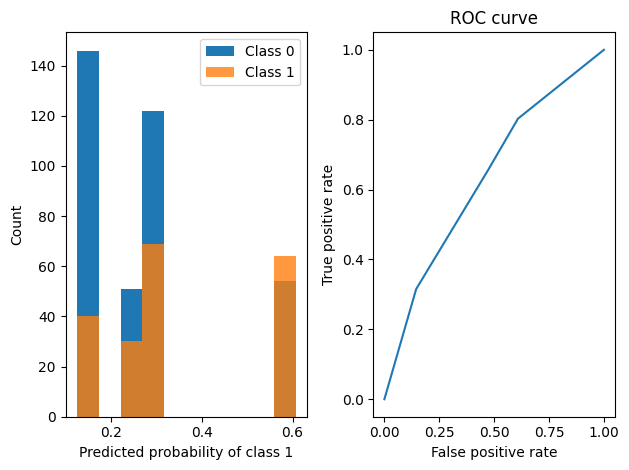

In [7]:
# fit a oneR model
model = OneRClassifier()
model.fit(X_train, y=y_train, feature_names=feat_names) # stores into m.rules_
probs = model.predict_proba(X_test)
preds = model.predict(X_test)

# print the rule list
print("Classifier Accuracy:", np.mean(y_test == preds), "\n Learned interpretable model:\n", model)

# look at prediction breakdown
viz_classification_preds(probs, y_test)

In [8]:
model.rules_

[{'col': '#Pregnant',
  'index_col': 0,
  'cutoff': 6.5,
  'val': 0.24113475177304963,
  'flip': False,
  'val_right': 0.6078431372549019,
  'num_pts': 192,
  'num_pts_right': 51},
 {'col': '#Pregnant',
  'index_col': 0,
  'cutoff': 2.5,
  'val': 0.1951219512195122,
  'flip': False,
  'val_right': 0.3050847457627119,
  'num_pts': 141,
  'num_pts_right': 59},
 {'col': '#Pregnant',
  'index_col': 0,
  'cutoff': 0.5,
  'val': 0.15384615384615385,
  'flip': True,
  'val_right': 0.26666666666666666,
  'num_pts': 82,
  'num_pts_right': 30},
 {'col': '#Pregnant',
  'index_col': 0,
  'cutoff': 1.5,
  'val': 0.125,
  'flip': False,
  'val_right': 0.2,
  'num_pts': 52,
  'num_pts_right': 20}]

In [9]:
# @title verify

def predict_with_rules(df, rules, baseline_risk=0, threshold=0.5):
    """
    Predict risk and labels based on Greedy Rule List.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing feature columns.
    - rules (list of dict): List of rules in the order they should be applied.
    - baseline_risk (float): The default risk if no rules match.
    - threshold (float): Threshold to convert risk to binary label.

    Returns:
    - pd.DataFrame: DataFrame with additional 'predicted_risk' and 'predicted_label' columns.
    """
    # Initialize predicted risk with baseline
    df = df.copy()
    df['predicted_risk'] = baseline_risk
    df['predicted_label'] = 0  # Initialize with default label

    # Create a mask to identify which rows have been assigned a risk
    assigned_mask = pd.Series([False] * len(df), index=df.index)

    for rule in rules:
        if 'col' in rule:
            col = rule['col']
            cutoff = rule['cutoff']
            flip = rule['flip']
            val_right = rule['val_right']
            val = rule['val']

            # # Define the condition based on 'flip'
            if not flip:
                condition1 = (df[col] > cutoff) & (~assigned_mask)
                condition2 = (df[col] <= cutoff) & (~assigned_mask)
            else:
                condition1 = (df[col] <= cutoff) & (~assigned_mask)
                condition2 = (df[col] > cutoff) & (~assigned_mask)

            # Assign the risk where condition is True
            df.loc[condition1, 'predicted_risk'] = val_right
            df.loc[condition2, 'predicted_risk'] = val
            #print(np.sum(condition))

            # Update the assigned mask
            assigned_mask = assigned_mask | condition1
        else:
            df[~assigned_mask] = val = rule['val']
    # Assign labels based on the threshold
    df['predicted_label'] = (df['predicted_risk'] >= threshold).astype(int)

    return df

In [10]:
df_with_predictions = predict_with_rules(pd.DataFrame(X_test, columns=feat_names), model.rules_, baseline_risk=model.rules_[0]['val'], threshold=0.5)

In [11]:
y_pred = df_with_predictions['predicted_label']

In [12]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Classifier Accuracy: {accuracy * 100:.2f}%")

Classifier Accuracy: 66.49%


### [Greedy rule lists](https://csinva.io/imodels/rule_list/greedy_rule_list.html)

Like a decision tree that only ever splits going left!

Classifier Accuracy: 0.6319444444444444 
 Learned interpretable model:
 > ------------------------------
> Greedy Rule List
> ------------------------------
↓
6.78% risk (192 pts)
	if Glucose concentration test ==> 45.9% risk (133 pts)
↓
3.57% risk (59 pts)
	if Triceps skin fold thickness(mm) ==> 66.7% risk (3 pts)
↓
1.82% risk (56 pts)
	if 2-Hour serum insulin (mu U/ml) ==> 100.0% risk (1 pts)
↓
0.0% risk (55 pts)
	if ~Diabetes pedigree function ==> 25.0% risk (4 pts)
↓
0.0% risk (51 pts)



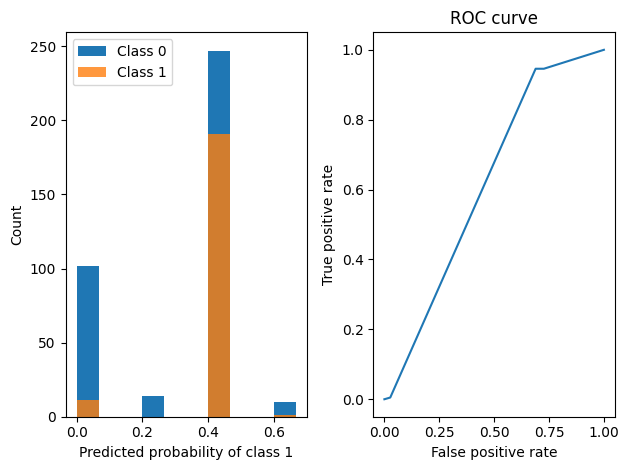

In [13]:
# fit a greedy rule list
model = GreedyRuleListClassifier()
model.fit(X_train, y=y_train, feature_names=feat_names)  # stores into m.rules_
probs = model.predict_proba(X_test)
preds = model.predict(X_test)

# print the rule list
print("Classifier Accuracy:", np.mean(y_test == preds), "\n Learned interpretable model:\n", model)

# look at prediction breakdown
viz_classification_preds(probs, y_test)

In [14]:
model.rules_

[{'col': 'Glucose concentration test',
  'index_col': 1,
  'cutoff': 99.5,
  'val': 0.06779661016949153,
  'flip': False,
  'val_right': 0.45864661654135336,
  'num_pts': 192,
  'num_pts_right': 133},
 {'col': 'Triceps skin fold thickness(mm)',
  'index_col': 3,
  'cutoff': 39.5,
  'val': 0.03571428571428571,
  'flip': False,
  'val_right': 0.6666666666666666,
  'num_pts': 59,
  'num_pts_right': 3},
 {'col': '2-Hour serum insulin (mu U/ml)',
  'index_col': 4,
  'cutoff': 224.0,
  'val': 0.01818181818181818,
  'flip': False,
  'val_right': 1.0,
  'num_pts': 56,
  'num_pts_right': 1},
 {'col': 'Diabetes pedigree function',
  'index_col': 6,
  'cutoff': 0.1639999970793724,
  'val': 0.0,
  'flip': True,
  'val_right': 0.25,
  'num_pts': 55,
  'num_pts_right': 4},
 {'val': 0.0, 'num_pts': 51}]

In [15]:
df_with_predictions = predict_with_rules(pd.DataFrame(X_test, columns=feat_names), model.rules_, baseline_risk=model.rules_[0]['val'], threshold=0.5)
y_pred = df_with_predictions['predicted_label']
accuracy = accuracy_score(y_test, y_pred)
print(f"Classifier Accuracy: {accuracy * 100:.2f}%")

Classifier Accuracy: 63.19%


## Rule sets


Rule sets are models that create a set of (potentially overlapping) rules.

### [Rulefit](https://christophm.github.io/interpretable-ml-book/rulefit.html)

It fits a sparse linear model on rules extracted from decision trees

In [16]:
# fit a rulefit model
model = RuleFitRegressor(max_rules=10)
model.fit(X_train_reg, y_train_reg, feature_names=feat_names_reg)

# get test performance
preds = model.predict(X_test_reg)
print(f'test mse: {metrics.mean_squared_error(y_test_reg, preds):0.2f}')
print(f'test r2: {metrics.r2_score(y_test_reg, preds):0.2f}')

model

test mse: 2119188865.56
test r2: 0.67


RuleFitRegressor(max_rules=10)

In [17]:
model._get_rules()

rule    type          coef  \
0                                      MSSubClass  linear     -0.000000   
1                                         LotArea  linear      0.000000   
2                                     OverallQual  linear  16445.578766   
3                                     OverallCond  linear      0.000000   
4                                       YearBuilt  linear      0.000000   
5                                    YearRemodAdd  linear      0.000000   
6                                      BsmtFinSF1  linear      0.000000   
7                                      BsmtFinSF2  linear     -0.000000   
8                                       BsmtUnfSF  linear      0.000000   
9                                     TotalBsmtSF  linear      0.461150   
10                                       1stFlrSF  linear      0.000000   
11                                       2ndFlrSF  linear      0.000000   
12                                   LowQualFinSF  linear      0.000000   
13                                      GrLivArea  linear     30.199063   
14                                   BsmtFullBath  linear      0.000000   
15                                   BsmtHalfBath  linear     -0.000000   
16                                       FullBath  linear      0.000000   
17                                       HalfBath  linear      0.000000   
18                                   BedroomAbvGr  linear      0.000000   
19                                   KitchenAbvGr  linear     -0.000000   
20                                   TotRmsAbvGrd  linear      0.000000   
21                                     Fireplaces  linear      0.000000   
22                                     GarageCars  linear      0.000000   
23                                     GarageArea  linear     21.756267   
24                                     WoodDeckSF  linear      0.000000   
25                                    OpenPorchSF  linear      0.000000   
26                                  EnclosedPorch  linear     -0.000000   
27                                      3SsnPorch  linear      0.000000   
28                                    ScreenPorch  linear      0.000000   
29                                       PoolArea  linear      0.000000   
30                                        MiscVal  linear      0.000000   
31                                         MoSold  linear      0.000000   
32                                         YrSold  linear     -0.000000   
33     OverallQual <= 7.5 and YearBuilt <= 1994.5    rule  -5512.257389   
34  GrLivArea <= 1928.5 and TotalBsmtSF <= 1089.0    rule  -3143.052069   
35     1stFlrSF <= 1489.0 and YearBuilt <= 1985.0    rule  -4368.451524   
36  GrLivArea <= 1934.0 and TotalBsmtSF <= 1199.0    rule  -8555.449730   
37  GrLivArea <= 2251.5 and TotalBsmtSF <= 1427.0    rule -16791.538181   
38                            GrLivArea <= 1729.5    rule  -3534.251441   

     support    importance  
0   1.000000      0.000000  
1   1.000000      0.000000  
2   1.000000  21148.679667  
3   1.000000      0.000000  
4   1.000000      0.000000  
5   1.000000      0.000000  
6   1.000000      0.000000  
7   1.000000      0.000000  
8   1.000000      0.000000  
9   1.000000    200.445860  
10  1.000000      0.000000  
11  1.000000      0.000000  
12  1.000000      0.000000  
13  1.000000  13834.156476  
14  1.000000      0.000000  
15  1.000000      0.000000  
16  1.000000      0.000000  
17  1.000000      0.000000  
18  1.000000      0.000000  
19  1.000000      0.000000  
20  1.000000      0.000000  
21  1.000000      0.000000  
22  1.000000      0.000000  
23  1.000000   4329.789359  
24  1.000000      0.000000  
25  1.000000      0.000000  
26  1.000000      0.000000  
27  1.000000      0.000000  
28  1.000000      0.000000  
29  1.000000      0.000000  
30  1.000000      0.000000  
31  1.000000      0.000000  
32  1.000000      0.000000  
33  0.638356   2648.509591  
34  0.536986   1567.220484  


In [18]:
rules = model._get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)
# 'rule' is how the feature is constructed
# 'coef' is its weight in the final linear model
# 'support' is the fraction of points it applies to
rules[['rule', 'coef', 'support']].style.background_gradient(cmap='viridis')

## Ruletree

### [FIGSClassifier](https://csinva.io/imodels/figs.html)

Predictions are made by summing the value obtained from the appropriate leaf of each tree

Classifier Accuracy: 0.7152777777777778 
 Learned interpretable model:
 > ------------------------------
> FIGS-Fast Interpretable Greedy-Tree Sums:
> 	Predictions are made by summing the "Val" reached by traversing each tree.
> 	For classifiers, a sigmoid function is then applied to the sum.
> ------------------------------
Glucose concentration test <= 99.500 (Tree #0 root)
	Val: 0.068 (leaf)
	Glucose concentration test <= 168.500 (split)
		#Pregnant <= 6.500 (split)
			Body mass index <= 30.850 (split)
				Val: 0.065 (leaf)
				Blood pressure(mmHg) <= 67.000 (split)
					Val: 0.705 (leaf)
					Val: 0.303 (leaf)
			Val: 0.639 (leaf)
		Blood pressure(mmHg) <= 93.000 (split)
			Val: 0.860 (leaf)
			Val: -0.009 (leaf)

	+
Diabetes pedigree function <= 0.404 (Tree #1 root)
	Val: -0.088 (leaf)
	Val: 0.106 (leaf)



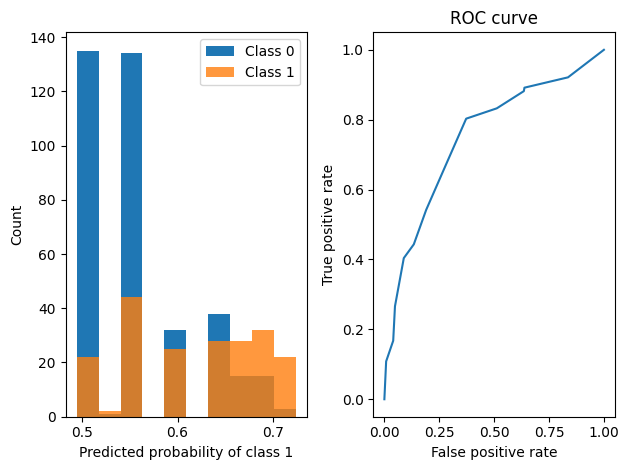

In [19]:
# specify a decision tree with a maximum depth
figs = FIGSClassifier(max_rules=7)
figs.fit(X_train, y_train, feature_names=feat_names)

# calculate mse on the training data
probs = figs.predict_proba(X_test)
preds = figs.predict(X_test)

print("Classifier Accuracy:", np.mean(y_test == preds), "\n Learned interpretable model:\n", figs)

viz_classification_preds(probs, y_test)

Alternative visualization:


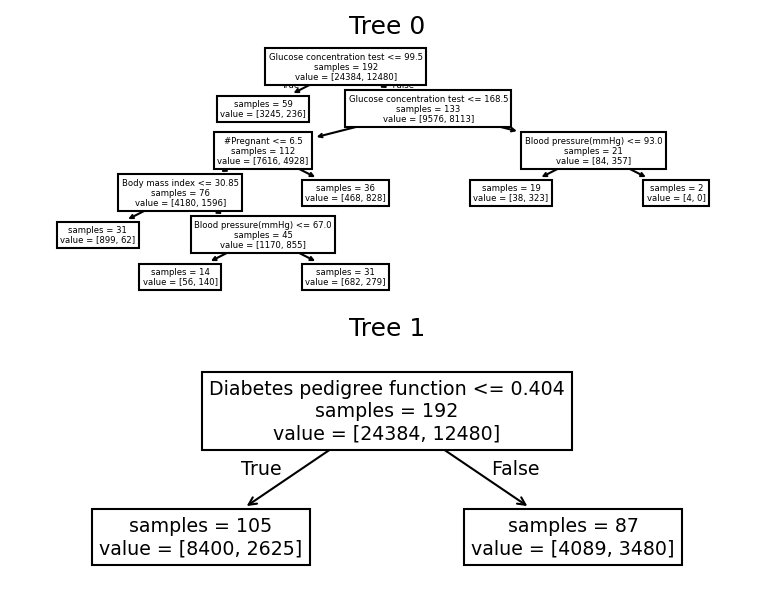

In [20]:
print('Alternative visualization:')
figs.plot()

In [21]:
dt = extract_sklearn_tree_from_figs(figs, tree_num=0, n_classes=2) # tree_num =  0 or 1
viz_model = dtreeviz.model(dt,
                           X_train=X_train, y_train=y_train,
                           feature_names=feat_names,
                           target_name='y', class_names=[0, 1])

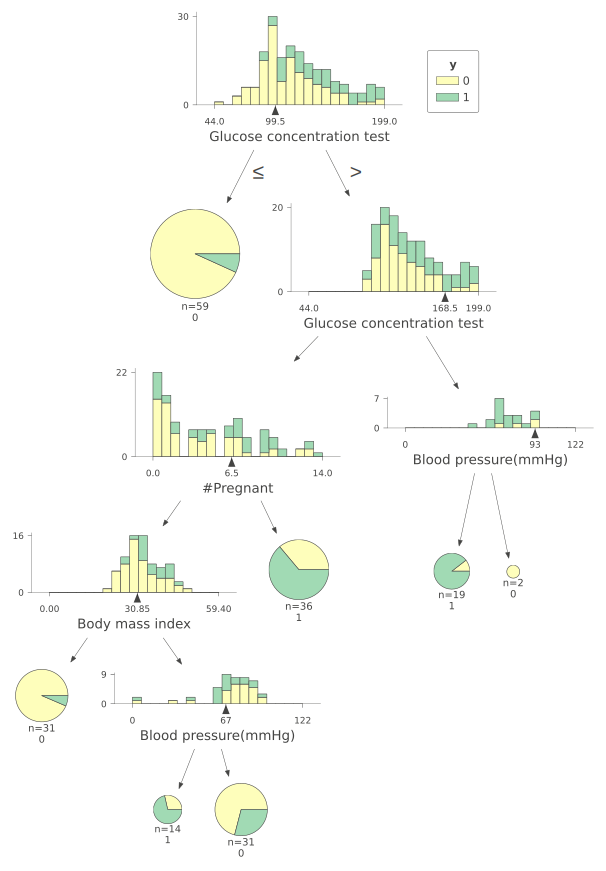

In [22]:
viz_model.view(scale=1.5)

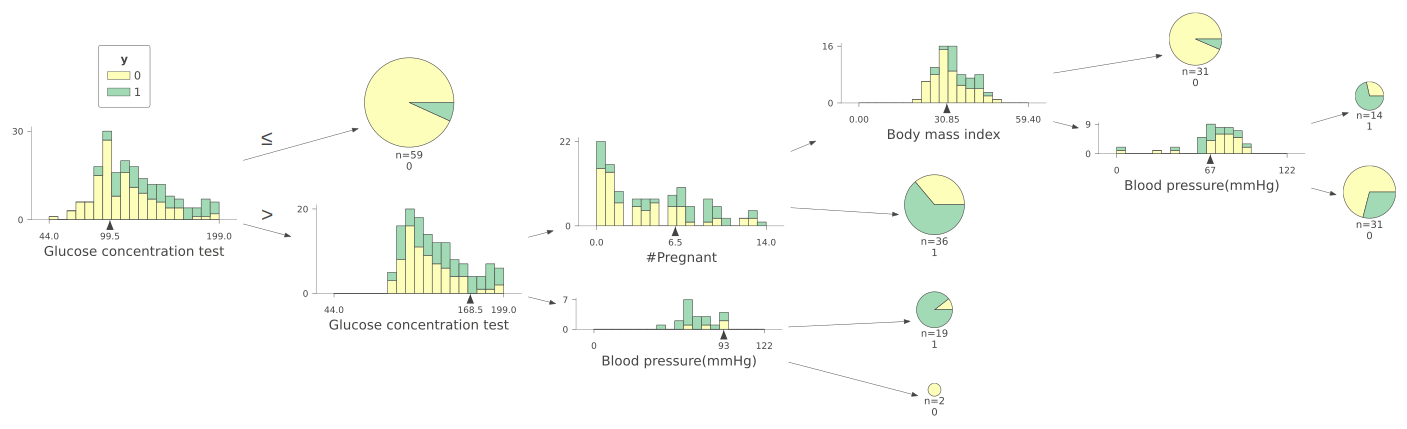

In [23]:
viz_model.view(orientation="LR", scale=1.5)

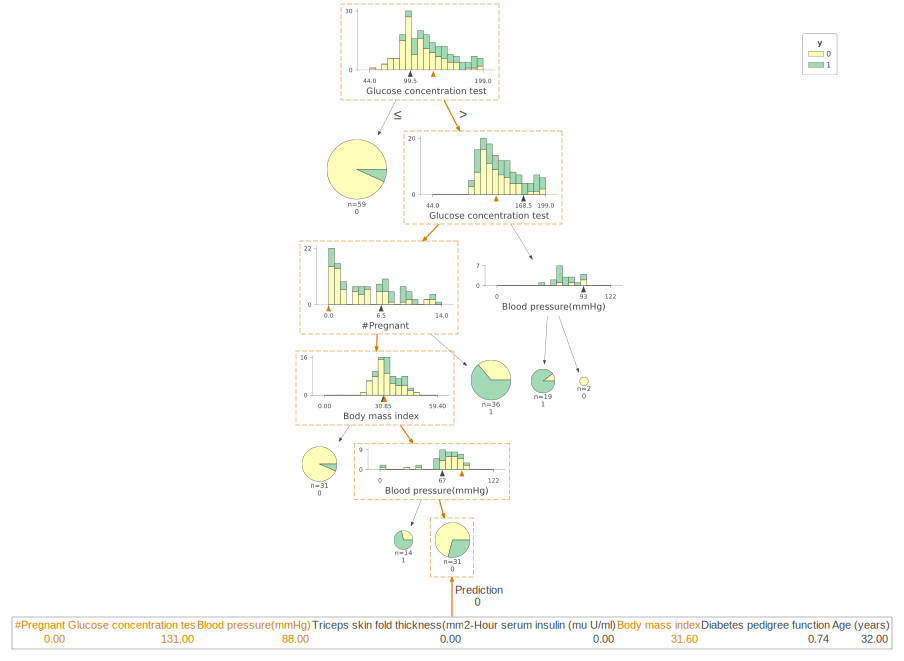

In [24]:
x_example = X_train[13]
viz_model.view(x=x_example)

See https://github.com/parrt/dtreeviz/blob/master/notebooks/dtreeviz_sklearn_visualisations.ipynb for more information.

# 📘 Explainable Boosting Machine (EBM) by InterpretML

At their core, EBMs are generalized additive models where the score contributions from individual features and interactions are added together to make a prediction. Regression is the simplest form of EBM model because the final sum is the actual prediction without requiring an inverse link function.

> Each individual score contribution is determined using a lookup table. Before doing the lookup, we first need to discretize continuous features and assign bin indexes to categorical features.

In [25]:
dataset = fetch_california_housing()
X = dataset.data
y = dataset.target
names = dataset.feature_names

seed = 42
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

Introducing more interactions tends to improve model accuracy. Values between 0 and LESS than 1.0 are interpreted as percentages of the number of features. For example, a dataset with 100 features and an interactions value of 0.75 will automatically detect and use 75 interactions. Values of 1 or higher indicate the exact number of interactions to be detected, so for example 1 would create 1 interaction, and 50 would create 50.

In [32]:
ebm = ExplainableBoostingRegressor(names, interactions=3)
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor(feature_names=['MedInc', 'HouseAge', 'AveRooms',
                                            'AveBedrms', 'Population',
                                            'AveOccup', 'Latitude',
                                            'Longitude'],
                             interactions=3)

Let’s have a look at some of the most important attributes of the [`ExplainableBoostingRegressor`](https://interpret.ml/docs/ebm-internals-regression.html).

In [39]:
ebm.feature_types_in_

['continuous',
 'continuous',
 'continuous',
 'continuous',
 'continuous',
 'continuous',
 'continuous',
 'continuous']

> Adjusts a term to be monotone using isotonic regression. An important consideration is that this function only adjusts a single term and will not modify pairwise terms. When a feature needs to be globally monotonic, any pairwise terms that include the feature should be excluded from the model.Applying a monotonic constraint to the MedInc feature in the California Housing dataset using an Explainable Boosting Regressor is a strategic move grounded in domain knowledge and aimed at enhancing model interpretability, reliability, and alignment with expected economic relationships.

In [27]:
# post-process monotonize the MedInc feature
# ebm.monotonize("MedInc", increasing=True)

ExplainableBoostingRegressor(feature_names=['MedInc', 'HouseAge', 'AveRooms',
                                            'AveBedrms', 'Population',
                                            'AveOccup', 'Latitude',
                                            'Longitude'],
                             interactions=3)

In [34]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

In [35]:
ebm_local = ebm.explain_local(X_test[:5], y_test[:5], name='EBM')
show(ebm_local, 0)

In [36]:
ebm_perf = RegressionPerf(ebm, names).explain_perf(X_test, y_test, name='EBM')
show(ebm_perf)

# 📘 Partial Depedency Plot and Individual Conditional Expectation plots

Partial dependence plots (PDP) and individual conditional expectation (ICE) plots can be used to visualize and analyze interaction between the target response 1 and a set of input features of interest.

Both PDPs and ICEs **assume that the input features of interest are independent from the complement features**, and this assumption is often violated in practice. Thus, in the case of correlated features, we will create absurd data points to compute the PDP/ICE.

## Partial dependence plots

Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, **marginalizing over the values of all other input features (the 'complement' features).** Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.

Due to the limits of human perception the size of the set of input feature of interest must be small (usually, one or two) **thus the input features of interest are usually chosen among the most important features.**



In [40]:
cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target

y -= y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

### 1-way partial dependence with different models

Note that it is important to **check that the model is accurate enough on a test set before plotting the partial dependence** since there would be little use in explaining the impact of a given feature on the prediction function of a poor model.

In [41]:
est = HistGradientBoostingRegressor(random_state=0) # Similar to lightgbm
est.fit(X_train, y_train)
print(f"Test R2 score: {est.score(X_test, y_test):.2f}")

Test R2 score: 0.85


The `sklearn.inspection` module provides a convenience function `from_estimator` to create one-way and two-way partial dependence plots.

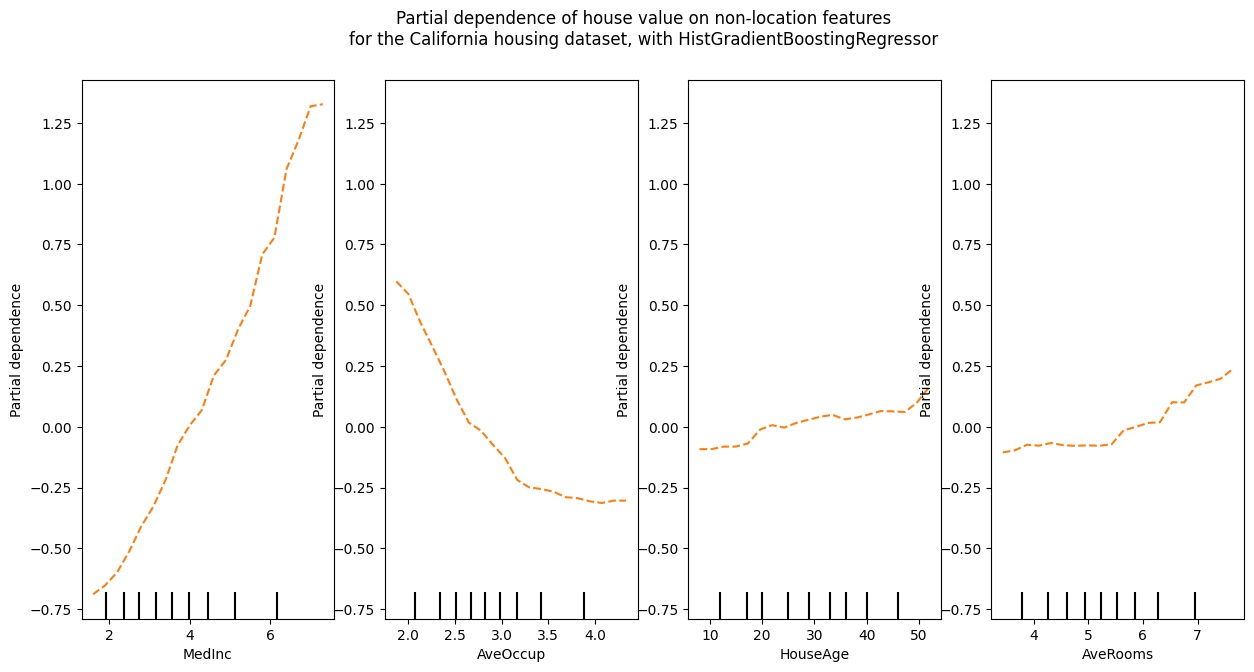

In [42]:
features = ["MedInc", "AveOccup", "HouseAge", "AveRooms"]
_, ax = plt.subplots(ncols=4, figsize=(15, 7))
display = PartialDependenceDisplay.from_estimator(
    est,
    X_train,
    features,
    grid_resolution=20,
    ax = ax,
    random_state=0,
    pd_line_kw={"color": "tab:orange", "linestyle": "--"}
)
display.figure_.suptitle(
    "Partial dependence of house value on non-location features\n"
    "for the California housing dataset, with HistGradientBoostingRegressor"
)
display.figure_.subplots_adjust(hspace=2)

We can clearly see on the PDPs (dashed orange line) that the median house price shows a linear relationship with the median income (left) and that the house price drops when the average occupants per household increases (middle). The right plots show that the house age in a district does not have a strong influence on the (median) house price; so does the average rooms per household.

One-way PDPs tell us about the interaction between the target response and an input feature of interest feature (e.g. linear, non-linear).

### 2D Partial Dependence Plots

PDPs with two features of interest enable us to visualize interactions among them. Another consideration is linked to the performance to compute the PDPs. With the tree-based algorithm, when only PDPs are requested, they can be computed on an efficient way using the 'recursion' method.

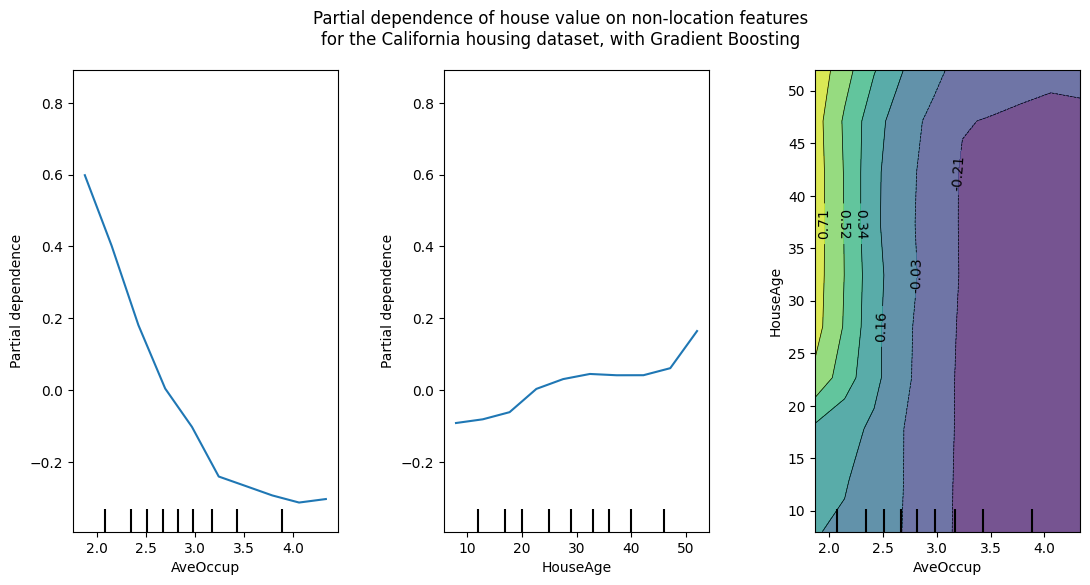

In [43]:
features = ["AveOccup", "HouseAge", ("AveOccup", "HouseAge")]
_, ax = plt.subplots(ncols=3, figsize=(13, 6))
display = PartialDependenceDisplay.from_estimator(
    est,
    X_train,
    features,
    kind="average",
    grid_resolution=10,
    ax=ax,
)

display.figure_.suptitle(
    "Partial dependence of house value on non-location features\n"
    "for the California housing dataset, with Gradient Boosting"
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

The left plot in the above figure shows the effect of the average occupancy on the median house price; we can clearly see a linear relationship among them when the average occupancy is inferior to 3 persons. Similarly, we could analyze the effect of the house age on the median house price (middle plot). Thus, these interpretations are marginal, considering a feature at a time.

The two-way partial dependence plot shows the dependence of median house price on joint values of house age and average occupants per household. We can clearly see an interaction between the two features: **for an average occupancy greater than two, the house price is nearly independent of the house age, whereas for values less than two there is a strong dependence on age.**

If you need the raw values of the partial dependence function rather than the plots, you can use the `sklearn.inspection.partial_dependence()` function.

### 🔍 Another example

Like permutation importance, partial dependence plots are calculated **after a model has been fit.** The model is fit on real data that has not been artificially manipulated in any way. Our example will use a model that predicts whether a soccer/football team will have the "Man of the Game" winner based on the team's statistics. The "Man of the Game" award is given to the best player in the game.

Teams may differ in many ways. How many passes they made, shots they took, goals they scored, etc. At first glance, it seems difficult to disentangle the effect of these features. To see how partial plots separate out the effect of each feature, we start by considering a single row of data. For example, that row of data might represent a team that had the ball 50% of the time, made 100 passes, took 10 shots and scored 1 goal.

We will use the fitted model to predict our outcome (probability their player won "man of the match"). **But we repeatedly alter the value for one variable to make a series of predictions.** We could predict the outcome if the team had the ball only 40% of the time. We then predict with them having the ball 50% of the time. Then predict again for 60%. And so on. We trace out predicted outcomes (on the vertical axis) as we move from small values of ball possession to large values (on the horizontal axis).

In this description, we used only a single row of data. Interactions between features may cause the plot for a single row to be atypical. So, we repeat that mental experiment with multiple rows from the original dataset, and we plot the average predicted outcome on the vertical axis.

In [44]:
data = pd.read_csv('FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
X

Goal Scored  Ball Possession %  Attempts  On-Target  Off-Target  Blocked  \
0              5                 40        13          7           3        3   
1              0                 60         6          0           3        3   
2              0                 43         8          3           3        2   
3              1                 57        14          4           6        4   
4              0                 64        13          3           6        4   
..           ...                ...       ...        ...         ...      ...   
123            1                 46        11          1           6        4   
124            2                 43        12          4           3        5   
125            0                 57        15          5           7        3   
126            4                 39         8          6           1        1   
127            2                 61        15          3           8        4   

     Corners  Offsides  Free Kicks  Saves  Pass Accuracy %  Passes  \
0          6         3          11      0               78     306   
1          2         1          25      2               86     511   
2          0         1           7      3               78     395   
3          5         1          13      3               86     589   
4          5         0          14      2               86     433   
..       ...       ...         ...    ...              ...     ...   
123        4         3          24      5               79     479   
124        4         1           5      5               88     510   
125        5         0          12      2               92     698   
126        2         1          14      1               75     271   
127        6         1          15      3               83     547   

     Distance Covered (Kms)  Fouls Committed  Yellow Card  Yellow & Red  Red  \
0                       118               22            0             0    0   
1                       105               10            0             0    0   
2                       112               12            2             0    0   
3                       111                6            0             0    0   
4                       101               22            1             0    0   
..                      ...              ...          ...           ...  ...   
123                     148               14            1             0    0   
124                     108               11            1             0    0   
125                     110                5            2             0    0   
126                      99               14            2             0    0   
127                     100               13            1             0    0   

     Goals in PSO  
0               0  
1               0  
2               0  
3               0  
4               0  
..            ...  
123             0  
124             0  
125             0  
126             0  
127             0  

[128 rows x 18 columns]

In [45]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

Our first example uses a decision tree, which you can see below. In practice, you'll use more sophistated models for real-world applications.

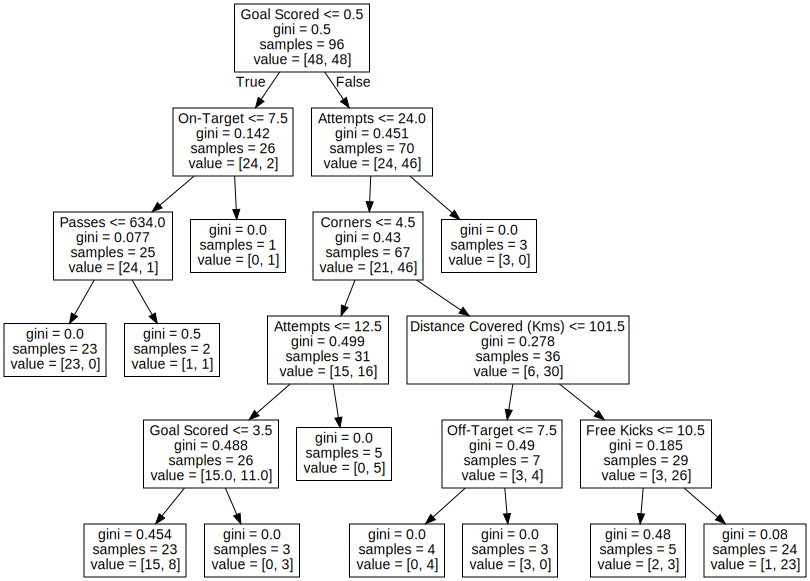

In [46]:
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names)
graphviz.Source(tree_graph)

In [47]:
feature_names

['Goal Scored',
 'Ball Possession %',
 'Attempts',
 'On-Target',
 'Off-Target',
 'Blocked',
 'Corners',
 'Offsides',
 'Free Kicks',
 'Saves',
 'Pass Accuracy %',
 'Passes',
 'Distance Covered (Kms)',
 'Fouls Committed',
 'Yellow Card',
 'Yellow & Red',
 'Red',
 'Goals in PSO']

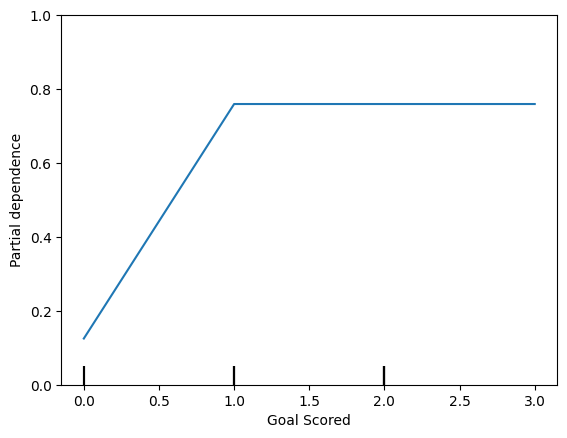

In [50]:
PartialDependenceDisplay.from_estimator(tree_model, val_X, features=['Goal Scored'], feature_names=feature_names)
plt.ylim(0,1);

A few items are worth pointing out as you interpret this plot

* The y axis is interpreted as **change in the prediction** from what it would be predicted at the baseline or leftmost value.
* A blue shaded area indicates level of confidence

From this particular graph, we see that scoring a goal substantially increases your chances of winning "Man of The Match."  But extra goals beyond that appear to have little impact on predictions.

Here is another example plot:

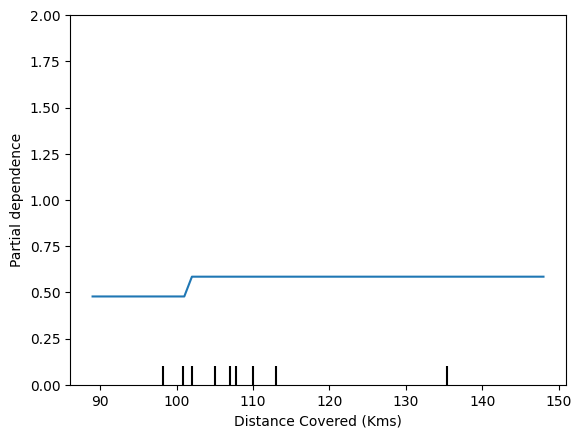

In [51]:
PartialDependenceDisplay.from_estimator(tree_model, val_X, features=['Distance Covered (Kms)'], feature_names=feature_names)
plt.ylim(0,2);

This graph seems too simple to represent reality. But that's because the model is so simple. You should be able to see from the decision tree above that this is representing exactly the model's structure.

You can easily compare the structure or implications of different models. Here is the same plot with a Random Forest model.

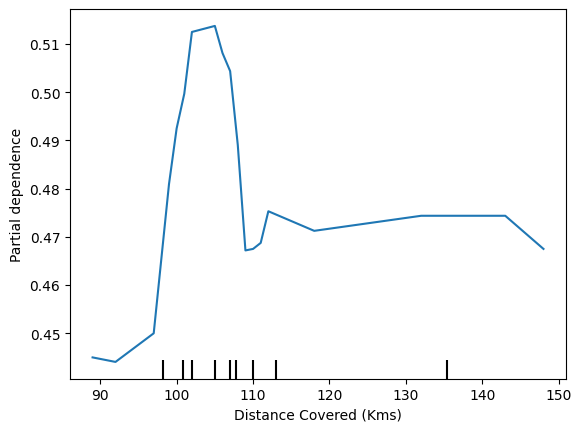

In [52]:
# Build Random Forest model
rf_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

PartialDependenceDisplay.from_estimator(rf_model, val_X, features=['Distance Covered (Kms)'], feature_names=feature_names);


This model thinks you are more likely to win *Man of the Match* if your players run a total of 100km over the course of the game. Though running much more causes lower predictions.

In general, the smooth shape of this curve seems more plausible than the step function from the Decision Tree model.  Though this dataset is small enough that we would be careful in how we interpret any model.

If you are curious about interactions between features, 2D partial dependence plots are also useful. An example may clarify this.  

We will again use the Decision Tree model for this graph.  It will create an extremely simple plot, but you should be able to match what you see in the plot to the tree itself.

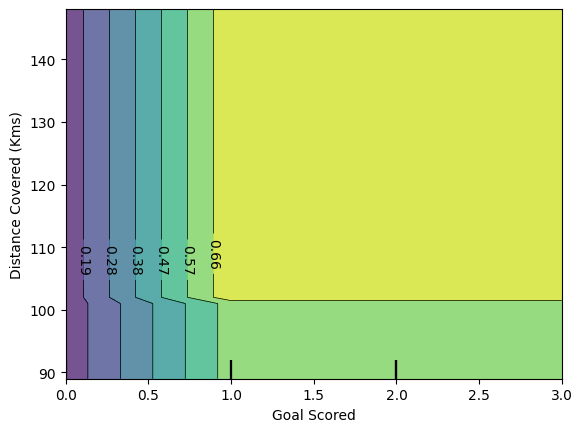

In [53]:
# Similar to previous PDP plot
PartialDependenceDisplay.from_estimator(tree_model, val_X, features=[('Goal Scored', 'Distance Covered (Kms)')], feature_names=feature_names);

This graph shows predictions for any combination of Goals Scored and Distance covered.

For example, we see the highest predictions when a team scores at least 1 goal and they run a total distance close to 100km. If they score 0 goals, distance covered doesn't matter. Can you see this by tracing through the decision tree with 0 goals?

But distance can impact predictions if they score goals. Make sure you can see this from the 2D partial dependence plot. Can you see this pattern in the decision tree too?

##  Individual conditional expectation (ICE) plot

Due to the limits of human perception, **only one input feature** of interest is supported for ICE plots.

While the PDPs are good at showing the average effect of the target features, they can obscure a **heterogeneous relationship** created by interactions. When interactions are present the ICE plot will provide many more insights. For example, we could observe a linear relationship between the median income and the house price in the PD line. However, the ICE lines show that there are some exceptions, where the house price remains constant in some ranges of the median income. We will plot the partial dependence, both individual (ICE) and averaged one (PDP). We limit to only 50 ICE curves to not overcrowd the plot.

The sklearn.inspection module’s `PartialDependenceDisplay.from_estimator `convenience function can be used to create ICE plots by setting `kind='individual'`. But in ICE plots it might not be easy to see the average effect of the input feature of interest. Hence, it is recommended to use ICE plots alongside PDPs. They can be plotted together with `kind='both'`.

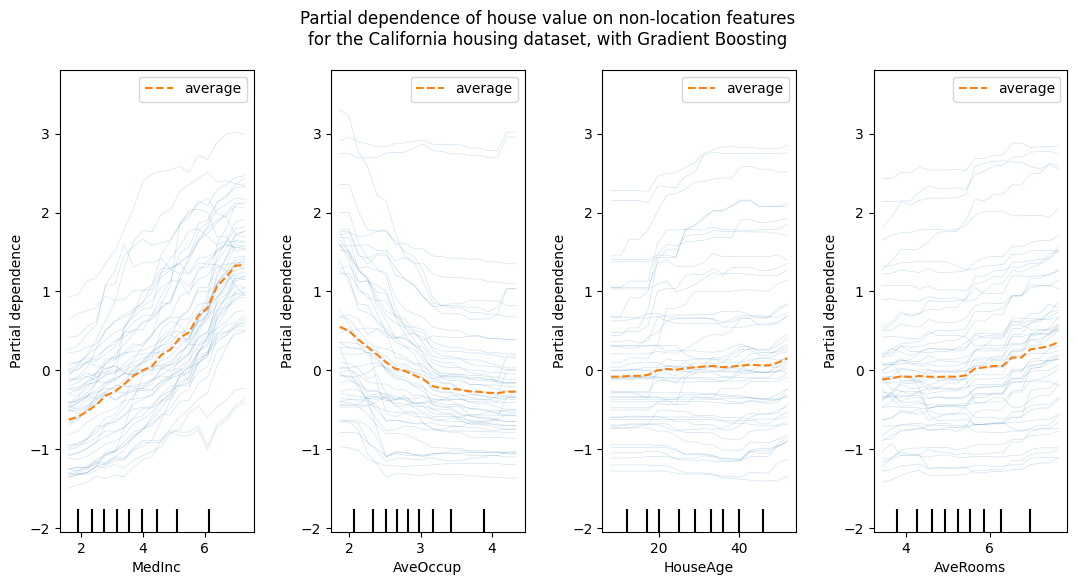

In [54]:
features = ["MedInc", "AveOccup", "HouseAge", "AveRooms"]
_, ax = plt.subplots(ncols=4, figsize=(13, 6))
display = PartialDependenceDisplay.from_estimator(
    est,
    X_train,
    features,
    kind="both",
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ax = ax,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)
display.figure_.suptitle(
    "Partial dependence of house value on non-location features\n"
    "for the California housing dataset, with Gradient Boosting"
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

The ICE curves (light blue lines) complement the analysis: we can see that there are some exceptions, where the house price remain constant with median income and average occupants. On the other hand, while the house age (top right) does not have a strong influence on the median house price on average, **there seems to be a number of exceptions where the house price increase when between the ages 15-25.** Similar exceptions can be observed for the average number of rooms (bottom left). Therefore, ICE plots show some individual effect which are attenuated by taking the averages.

Checkout more information at https://scikit-learn.org/stable/modules/partial_dependence.html# or https://github.com/SauceCat/PDPbox

# 📘 LIME

We'll use the Iris dataset, and we'll train a random forest.

In [55]:
np.random.seed(1)
iris = load_iris()
train, test, labels_train, labels_test = train_test_split(iris.data, iris.target, train_size=0.8)

In [56]:
rf = RandomForestClassifier(n_estimators=500)
rf.fit(train, labels_train)
metrics.accuracy_score(labels_test, rf.predict(test))

0.9666666666666667

## Tabular data

### Create the explainer

Tabular explainers need a training set. The reason for this is because we compute statistics on each feature (column). If the feature is numerical, we compute the mean and std, and discretize it into quartiles. If the feature is categorical, we compute the frequency of each value. For this part, we'll only look at numerical features.

We use these computed statistics for two things:

1. To scale the data, so that we can meaningfully compute distances when the attributes are not on the same scale
2. To sample perturbed instances - which we do by sampling from a `Normal(0,1)`, multiplying by the std and adding back the mean.

In [67]:
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=iris.feature_names, class_names=iris.target_names)

### Explaining an instance

Since this is a multi-class classification problem, we set the `top_labels` parameter, so that we only explain the top class.

In [72]:
np.random.seed(42)
i = np.random.randint(0, test.shape[0])
exp = explainer.explain_instance(test[i], rf.predict_proba, num_features=4, top_labels=1)

We now explain a single instance:

In [73]:
exp.show_in_notebook(show_table=True, show_all=True)

The way to interpret the weights by applying them to the prediction probabilities. See https://github.com/marcotcr/lime for more details.

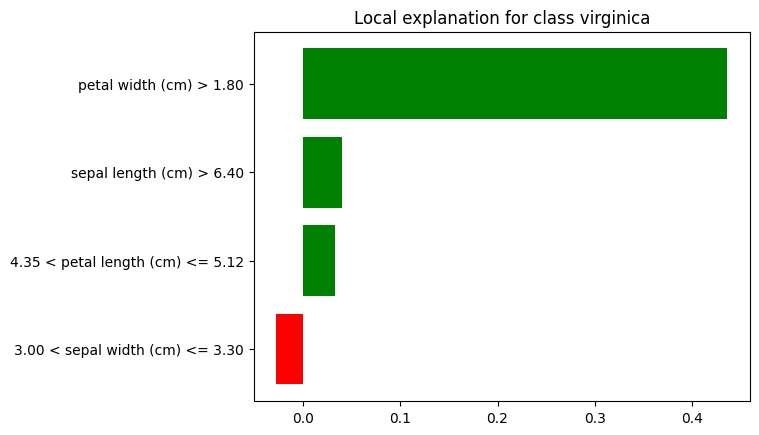

In [75]:
fig = exp.as_pyplot_figure(label=2) # 2 imples virginica

Now, there is a lot going on here. First, note that the row we are explained is displayed on the right side, in table format. Since we had the `show_all` parameter set to false, only the features used in the explanation are displayed.
The value column displays the original value for each feature.

Note that LIME has discretized the features in the explanation. This is because we let `discretize_continuous=True` in the constructor (this is the default). Discretized features make for more intuitive explanations.

## Image data

In [76]:
inet_model = tf.keras.applications.inception_v3.InceptionV3()

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [77]:
!wget https://raw.githubusercontent.com/marcotcr/lime/master/doc/notebooks/data/cat_mouse.jpg

--2024-10-07 10:48:45--  https://raw.githubusercontent.com/marcotcr/lime/master/doc/notebooks/data/cat_mouse.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248960 (243K) [image/jpeg]
Saving to: ‘cat_mouse.jpg’

cat_mouse.jpg       100%[===================>] 243.12K  --.-KB/s    in 0.02s   

2024-10-07 10:48:46 (10.5 MB/s) - ‘cat_mouse.jpg’ saved [248960/248960]



In [78]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(299, 299))
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = tf.keras.applications.inception_v3.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
('n02133161', 'American_black_bear', 0.63727975)
('n02105056', 'groenendael', 0.03180277)
('n02104365', 'schipperke', 0.02992133)
('n01883070', 'wombat', 0.028507343)
('n01877812', 'wallaby', 0.02509858)


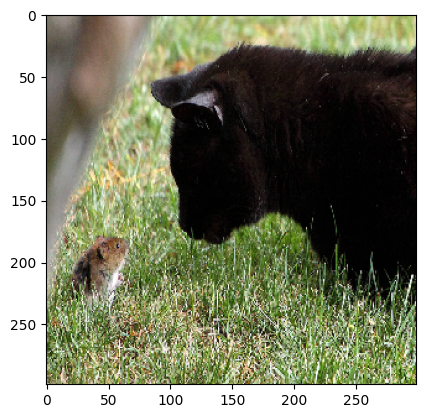

In [79]:
images = transform_img_fn(['cat_mouse.jpg'])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in tf.keras.applications.imagenet_utils.decode_predictions(preds)[0]:
    print(x)

### Explanation

Now let's get an explanation

In [80]:
explainer = lime_image.LimeImageExplainer()

In [81]:
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

### Now let's see the explanation for the classes

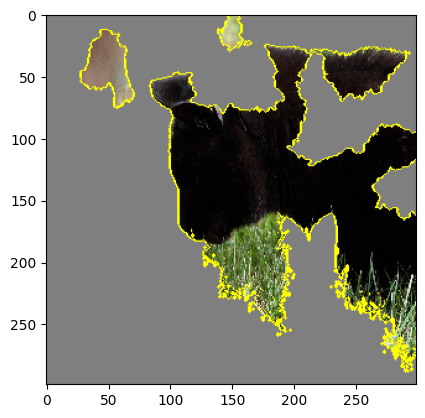

In [83]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask));

We can also see the 'pros and cons' (pros in green, cons in red)

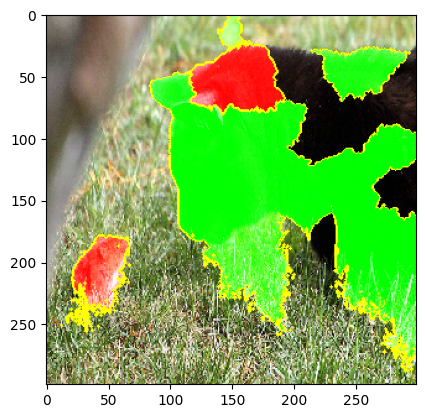

In [84]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask));

Alternatively, we can also plot explanation weights onto a heatmap visualization. The colorbar shows the values of the weights.

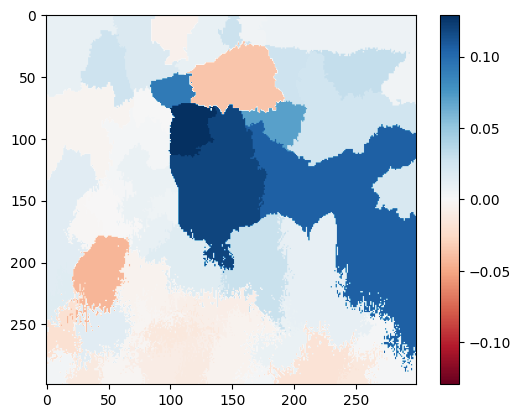

In [85]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar();

In [86]:
dict_heatmap

{20: 0.12931943767380047,
 26: 0.11880984386378499,
 25: 0.10555295616165314,
 14: 0.09102990721232657,
 17: 0.0698821381901301,
 34: -0.04306345132662024,
 10: -0.035573857313573244,
 11: 0.030451634445174448,
 32: 0.028860509645579038,
 4: 0.027839427118813924,
 9: 0.02686209001344805,
 12: 0.02638072876125614,
 19: 0.025457051314807,
 24: 0.02067411265643036,
 44: -0.019394753014668656,
 5: 0.018609959598418446,
 53: -0.01751706464813175,
 36: 0.015805275909535264,
 33: 0.015694348995736584,
 22: 0.014390702470269622,
 39: 0.014147911414883384,
 50: -0.01371700923994683,
 43: -0.013523555389562162,
 52: -0.01306087655004315,
 54: -0.011912908984296831,
 31: 0.010124463749655414,
 46: -0.009820145193419729,
 6: 0.009579781295632386,
 8: 0.009449541568071419,
 29: 0.009247647637267703,
 38: -0.009063521445973034,
 45: 0.008692318801495439,
 21: 0.008133291294799248,
 37: -0.007334471418600827,
 3: 0.006653688211304055,
 2: 0.0064248715810719375,
 7: 0.006067078989949748,
 27: 0.005265

Let's see the explanation for the wombat

In [90]:
temp.min(), temp.max()

(-1.0, 1.0)

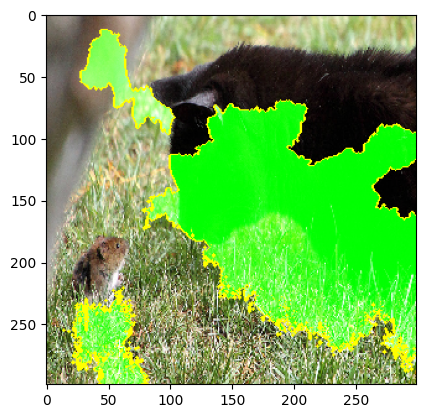

In [87]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[3], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask));

For more information, please refer to https://github.com/marcotcr/lime

# 📘 SHAP

## The force plot

An example is helpful, and we'll continue the soccer/football example from the partial dependence plots. In these part, we predicted whether **a team would have a player win the Man of the Match award.**

We could ask:
* How much was a prediction driven by the fact that the team scored 3 goals?

But it's easier to give a concrete, numeric answer if we restate this as:
* How much was a prediction driven by the fact that the team scored 3 goals, instead of some baseline number of goals.

Of course, each team has many features. So if we answer this question for number of goals, we could repeat the process for all other features.

In [12]:
data = pd.read_csv('FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

We will look at SHAP values for a single row of the dataset (we arbitrarily chose row 5). For context, we'll look at the raw predictions before looking at the SHAP values.

In [13]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
#data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

my_model.predict_proba(data_for_prediction.to_frame().T)

array([[0.29, 0.71]])

The team is 71% likely to have a player win the award.
Now, we'll move onto the code to get SHAP values for that single prediction.

In [14]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

The `shap_values` above is a `numpy` arrays with two columns. The first column is the SHAP values for a negative outcome (don't win the award), and the second column is the SHAP values for the positive outcome (wins the award). We typically think about predictions in terms of the prediction of a positive outcome, so we'll pull out SHAP values for positive outcomes (pulling out `shap_values[:,1]`).

It's cumbersome to review raw arrays, but the shap package has a nice way to visualize the results.

In [15]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[:,1], data_for_prediction) # You can use view output in full screen

If you look carefully at the code where we created the SHAP values, you'll notice we reference Trees in `shap.TreeExplainer(my_model)`.  But the SHAP package has explainers for every type of model.

* `shap.DeepExplainer` works with Deep Learning models.
* `shap.KernelExplainer` works with all models, though it is slower than other Explainers and it offers an approximation rather than exact Shap values.

## Summary Plots

In addition to this nice breakdown for each prediction, the [Shap library](https://github.com/slundberg/shap) offers great visualizations of groups of Shap values. We will focus on two of these visualizations. These visualizations have conceptual similarities to permutation importance and partial dependence plots.

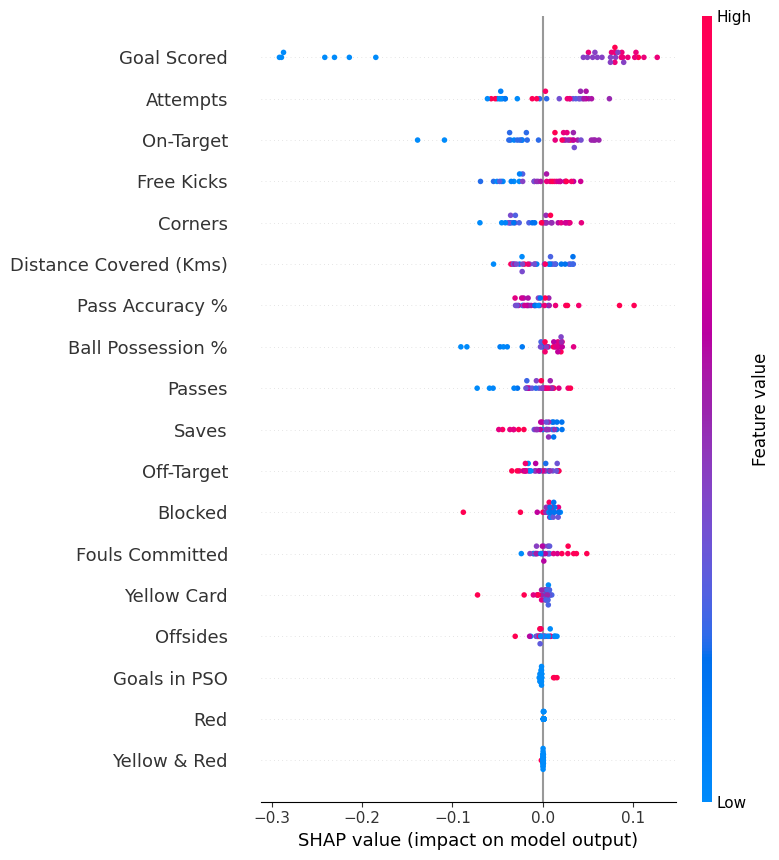

In [16]:
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[:,:,1], val_X)

The code isn't too complex. But there are a few caveats.

* When plotting, we call `shap_values[1]`.  For classification problems, there is a separate array of SHAP values for each possible outcome. In this case, **we index in to get the SHAP values for the prediction of "True".**
* Calculating SHAP values can be slow. It isn't a problem here, because this dataset is small.  But you'll want to be careful when running these to plot with reasonably sized datasets.  The exception is when using an `xgboost` model, which SHAP has some optimizations for and which is thus much faster.

This provides a great overview of the model, but we might want to delve into a single feature. That's where SHAP dependence contribution plots come into play.

## Dependence Contribution Plots

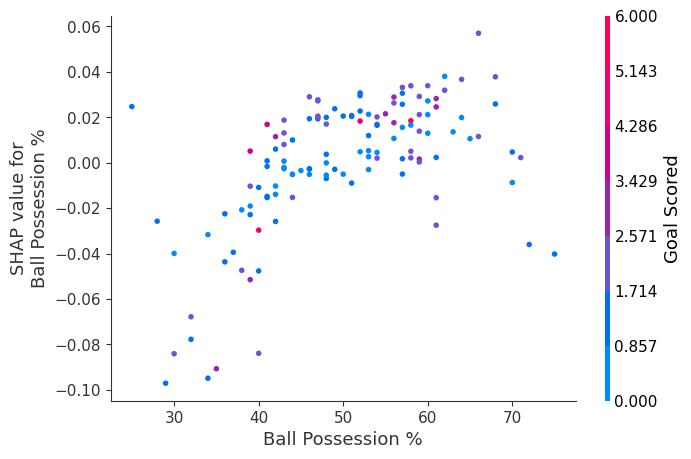

In [17]:
# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X)

# make plot.
shap.dependence_plot('Ball Possession %', shap_values[:,:,1], X, interaction_index="Goal Scored")

## Image data

Deep SHAP is a high-speed approximation algorithm for SHAP values in deep learning models that builds on a connection with DeepLIFT. The implementation here differs from the original DeepLIFT by using a distribution of background samples instead of a single reference value, and using Shapley equations to linearize components such as max, softmax, products, divisions, etc. Note that some of these enhancements have also been since integrated into DeepLIFT.

In [147]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

batch_size = 128
epochs = 3

model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_98 (Conv2D)                   │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_99 (Conv2D)                   │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │          16,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7818 - loss: 0.7253 - val_accuracy: 0.9770 - val_loss: 0.0832
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9622 - loss: 0.1222 - val_accuracy: 0.9842 - val_loss: 0.0549
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9720 - loss: 0.0903 - val_accuracy: 0.9878 - val_loss: 0.0463
Test loss: 0.047317344695329666
Test accuracy: 0.9854999780654907


In [148]:
# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[0:5])

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



In [149]:
shap_numpy = list(np.transpose(shap_values, (4, 0, 1, 2, 3)))

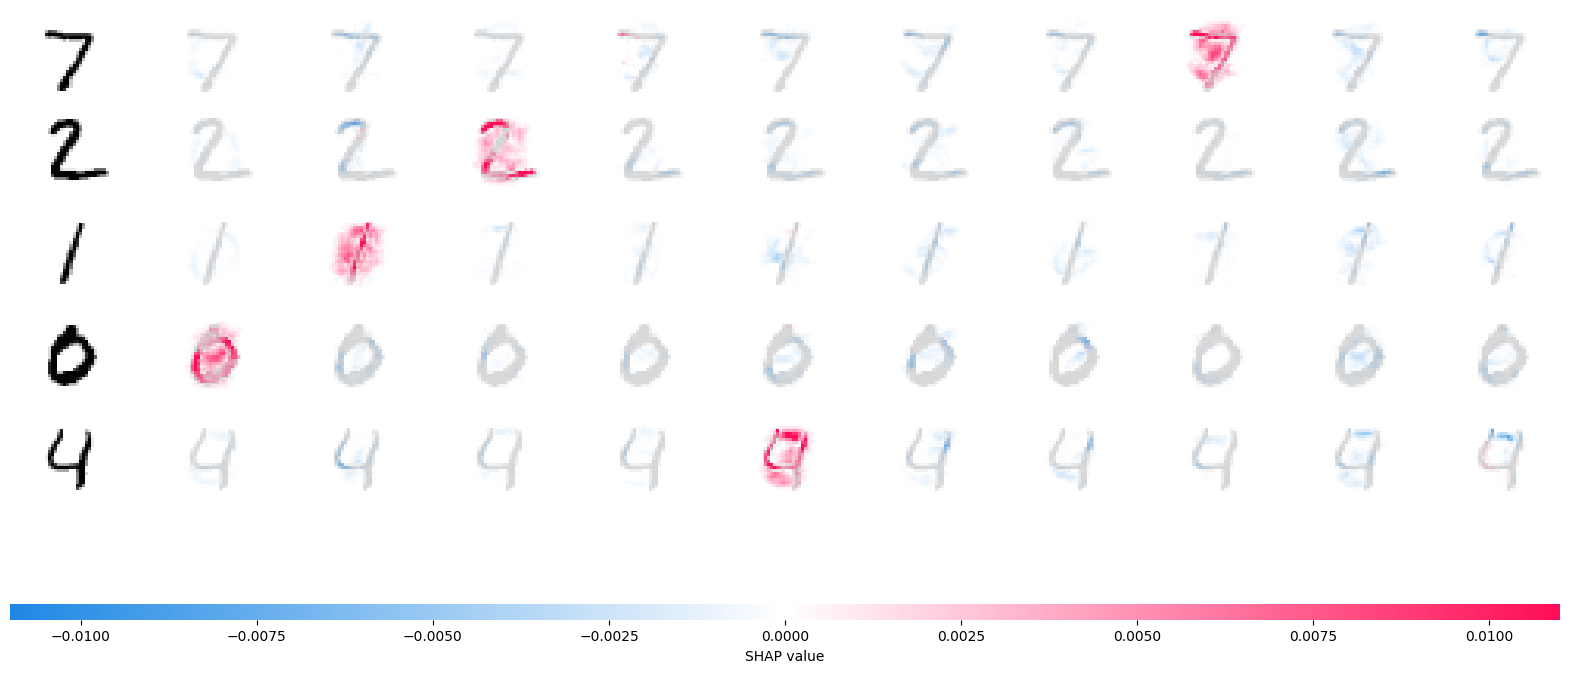

In [150]:
# plot the feature attributions
# 10 classes, thus we have 10 plots!
shap.image_plot(shap_numpy, -x_test[0:5])

The plot above explains ten outputs (digits 0-9) for four different images. Red pixels increase the model's output while blue pixels decrease the output. The input images are shown on the left, and as nearly transparent grayscale backings behind each of the explanations. The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset) and the current model output. Note that for the 'zero' image the blank middle is important, while for the 'four' image the lack of a connection on top makes it a four instead of a nine.

# 🔍 Protodash using AXI360

You can find more examples here https://github.com/Trusted-AI/AIX360/tree/master/examples/protodash

# 🔍 Counterfactual instances

You can find more informations here https://docs.seldon.io/projects/alibi/en/stable/methods/CFProto.html and https://github.com/interpretml/DiCE

# 🔍 Using Interpretable Features for Model Debugging

You can find more informations here https://github.com/dcai-course/dcai-lab/blob/master/interpretable_features/Solution%20-%20Interpretable%20Features.ipynb

# 📘 References

1. https://www.kaggle.com/learn/machine-learning-explainability
2. https://scikit-learn.org/stable/modules/partial_dependence.html#,
3. https://github.com/csinva/imodels
4. https://github.com/marcotcr/lime
5. https://github.com/slundberg/shap